In [1]:
cd ../..

/lfs/rambo/0/adobles/relbench-user-study


/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Feature Ideas

- For the following time periods:
    - All time
    - Prev 3 months
    - 3 - 6 months in the past
    - 6 - 9 months in the past
- Calculate the following features:
    - `weeks_since_first_review`: only for all time
    - `last_review_weeks_ago`: only for all time
    - `last_review_summary_text`: Embedding, only for all time
    - `last_reviewed_product_title`: Embedding, only for all time
    - `last_reviewed_product_category`: only for all time
    - `last_review_is_verified`: only for all time
    - `num_reviews`
    - `sum_review_ratings`
    - `avg_review_length`
    - `avg_review_rating`
    - `pct_verified_reviews`
    - `std_review_rating`
    - `min_review_rating`
    - `max_review_rating`
    - `avg_reviewed_product_rating`
    - `sum_reviewed_product_rating`
    - `std_reviewed_product_rating`
    - `min_reviewed_product_rating`
    - `max_reviewed_product_rating`
    - `avg_reviewed_product_price`
    - `sum_reviewed_product_price`
    - `std_reviewed_product_price`
    - `min_reviewed_product_price`
    - `max_reviewed_product_price`
    - `reviewed_product_modal_category`

In [2]:
import duckdb
from torch_frame.utils import infer_df_stype

import utils

conn = duckdb.connect('amazon/amazon.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True

In [53]:
with open('amazon/ltv/feats.sql', 'r') as f:
    # run once with train_labels and once with val_labels
    template = f.read()

# create train, val and test features
# takes 1 - 5 mins
for s in ['train', 'val', 'test']:
    print(f'Creating {s} table')
    query = utils.render_jinja_sql(template, dict(set=s, subsample=1_000_000))
    conn.sql(query)
    print(f'{s} table created')

Creating train table
train table created
Creating val table
val table created
Creating test table
test table created


In [4]:
utils.validate_feature_tables('ltv', conn)

Validating train
train labels size: 4,732,555 x 3
train feats size: 1,000,000 x 85
⚠️ 3,732,555 samples are missing from feats table!

Validating val
val labels size: 409,792 x 3
val feats size: 409,792 x 85

Validating test
test labels size: 351,885 x 2
test feats size: 351,885 x 84

❌ 1 errors found!


^-- Failure expected bc of subsampling

In [5]:
%%sql train_df <<
from ltv_train_feats

In [6]:
infer_df_stype(train_df)

{'customer_id': <stype.numerical: 'numerical'>,
 'timestamp': <stype.timestamp: 'timestamp'>,
 'ltv': <stype.numerical: 'numerical'>,
 'num_reviews_0_to_3': <stype.numerical: 'numerical'>,
 'sum_review_ratings_0_to_3': <stype.numerical: 'numerical'>,
 'avg_review_length_0_to_3': <stype.numerical: 'numerical'>,
 'avg_review_rating_0_to_3': <stype.numerical: 'numerical'>,
 'pct_verified_reviews_0_to_3': <stype.numerical: 'numerical'>,
 'std_review_rating_0_to_3': <stype.numerical: 'numerical'>,
 'min_review_rating_0_to_3': <stype.categorical: 'categorical'>,
 'max_review_rating_0_to_3': <stype.categorical: 'categorical'>,
 'avg_reviewed_product_rating_0_to_3': <stype.numerical: 'numerical'>,
 'sum_reviewed_product_rating_0_to_3': <stype.numerical: 'numerical'>,
 'std_reviewed_product_rating_0_to_3': <stype.numerical: 'numerical'>,
 'min_reviewed_product_rating_0_to_3': <stype.numerical: 'numerical'>,
 'max_reviewed_product_rating_0_to_3': <stype.numerical: 'numerical'>,
 'avg_reviewed_pr

In [8]:
utils.feature_summary_df(train_df.sample(20_000), 'ltv', classification=False)

,Label Corr.,Label MI,NaN %
num_reviews_0_to_3,0.392,0.069,0.0%
sum_review_ratings_0_to_3,0.384,0.069,0.9%
sum_reviewed_product_rating_0_to_3,0.390,0.065,0.9%
sum_reviewed_product_rating_3_to_6,0.339,0.065,66.0%
sum_reviewed_product_rating,0.306,0.064,0.3%
sum_review_ratings,0.302,0.063,0.3%
num_reviews,0.304,0.059,0.0%
sum_reviewed_product_price_3_to_6,0.246,0.059,66.0%
sum_review_ratings_3_to_6,0.337,0.059,66.0%
sum_review_ratings_6_to_9,0.317,0.056,72.3%


## Feature Importances

In [9]:
import numpy as np
import shap
from torch_frame import TaskType, stype
from torch_frame.data import Dataset
from torch_frame.gbdt import LightGBM

from inferred_stypes import task_to_stypes
from train_gbdt import TASK_PARAMS

TASK = 'rel-amazon-ltv'

task_params = TASK_PARAMS[TASK]

/lfs/local/0/adobles/miniconda3/envs/relbench/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
%%sql val_df <<
select * from ltv_val_feats;

In [11]:
col_to_stype = task_to_stypes[TASK].copy()
del col_to_stype['last_review_summary_text']
del col_to_stype['last_reviewed_product_title']
val_tf = Dataset(
    val_df,
    col_to_stype=col_to_stype,
    target_col=task_params['target_col'],
).materialize().tensor_frame

In [12]:
gbdt = LightGBM(task_type=task_params['task_type'])
gbdt.load(f'models/{TASK}_lgbm.json')
pred = gbdt.predict(tf_test=val_tf).numpy()

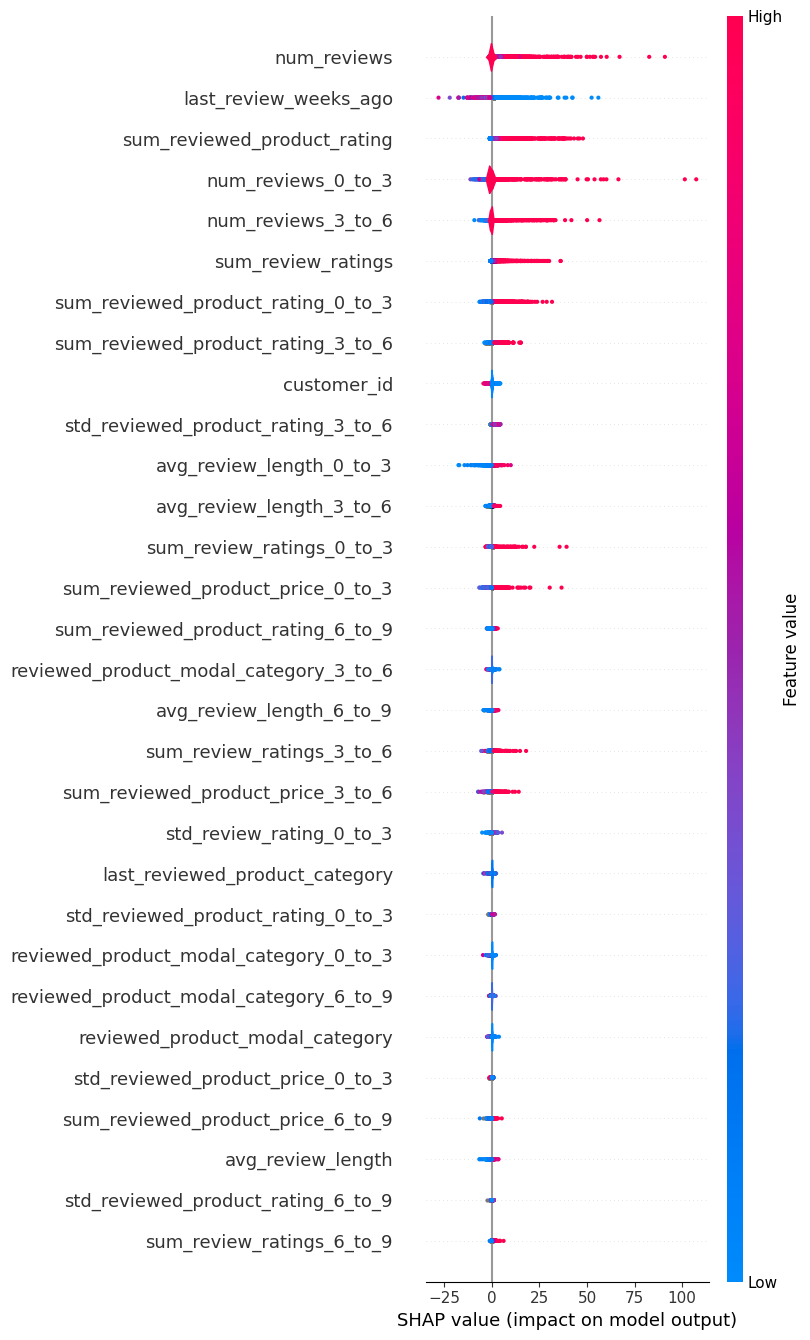

In [13]:
shap.initjs()
explainer = shap.TreeExplainer(gbdt.model)

sample = np.random.randint(0, len(val_tf), size=10_000)

val_arr, _, _ = gbdt._to_lightgbm_input(val_tf[sample])
shap_values = explainer.shap_values(val_arr, pred[sample])

# TODO verify
feat_names = val_tf.col_names_dict.get(stype.categorical, []) + val_tf.col_names_dict[stype.numerical]

shap.summary_plot(shap_values, val_arr, plot_type='violin', max_display=30, feature_names=feat_names)

In [14]:
conn.close()